In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [2]:
import keras
keras.__version__

'2.1.3'

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import json
import skimage.draw

In [5]:
%matplotlib inline 

# Directory to save logs and trained model
#MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [10]:
class GalaxiaConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "galaxia"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 8
    #IMAGES_PER_GPU = 3
    
    
    #BACKBONE = "resnet50"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    #IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 2 + 1  #  galaxia + Background 

    # Don't exclude based on confidence. Since we have two classes
    DETECTION_MIN_CONFIDENCE = 0.4
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    IMAGE_RESIZE_MODE = "crop"

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8,16, 32, 64, 128)  # anchor side in pixels
    
    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # Image mean (RGB)
    MEAN_PIXEL = np.array([10.71, 15.81, 19.04])
    

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128


    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200
   
    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400

    
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200


    ACTIVATION = 'relu'

    # Store masks inside the bounding boxes (looses some accuracy but speeds up training)
    USE_MINI_MASK = True

In [11]:
config = GalaxiaConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.4
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      8
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [8]:
import math

def plot_history(history):
    
    fig = plt.figure(figsize=(16,10))
       
    n_history_loss = len(history.history)
    n_epochs = len(history.epoch)
    epoch = history.epoch
    
    # The loss is in pairs, one for train, one for val
    loss_stats = [ k for k in history.history.keys() if 'val_' not in k ]
    
    n_cols = 4
    n_rows = math.ceil(len(loss_stats) / n_cols) 
    
    for i, k in enumerate(loss_stats):
        val_k = 'val_'+k
        ax = plt.subplot( n_rows, n_cols, i+1)
        ax.plot(epoch, history.history[k], label=k)
        ax.plot(epoch, history.history[val_k], label=val_k)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title(str(i)+' - '+k)
        plt.legend(shadow=True, fancybox=True)
    
    fig.tight_layout()
    plt.show()

## Notebook Preferences

In [9]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Class Dataset

In [10]:
class GalaxiaDataset(utils.Dataset):
    
    def load_galaxia(self, dataset_dir, subset):
        """Load a subset of the galaxia dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        #self.add_class("galaxia", 1, "U")
        self.add_class("galaxia", 1, "S")
        self.add_class("galaxia", 2, "E")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:

            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
                objects = [s['region_attributes'] for s in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
                objects = [s['region_attributes'] for s in a['regions']]
            

            
            class_ids = []
            
            for n in objects:
                #if(n['object_name'] == "U"):
                    #class_ids.append(1)
                if(n['object_name'] == "S"):
                    class_ids.append(1)
                if(n['object_name'] == "E"):
                    class_ids.append(2)           
            #print("class_ids = ",class_ids)
            
            
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "galaxia",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,class_ids=class_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a galaxia dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "galaxia":
            return super(self.__class__, self).load_mask(image_id)
        
        class_ids = image_info['class_ids']
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        #print("info['class_ids']=", info['class_ids'])
        class_ids = np.array(class_ids, dtype=np.int32)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        #return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
        return mask.astype(np.bool), class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "galaxia":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "galaxia":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



## Paths

In [11]:
MODEL_DIR = os.path.join(ROOT_DIR, "samples/zoo1/modelos")
MODEL_DIR

'/home/ubuntu/lab/mask_r_cnn/Mask_RCNN/samples/zoo1/modelos'

In [12]:
GALAXIA_DIR = os.path.join(ROOT_DIR, "samples/zoo1/dataset")
GALAXIA_DIR

'/home/ubuntu/lab/mask_r_cnn/Mask_RCNN/samples/zoo1/dataset'

In [13]:
%load_ext tensorboard

In [14]:
#%tensorboard --logdir samples/galaxia/modelos

##  Dataset

In [15]:
%%time
# Training dataset
dataset_train = GalaxiaDataset()
dataset_train.load_galaxia(GALAXIA_DIR, "train")
dataset_train.prepare()

CPU times: user 11.2 s, sys: 560 ms, total: 11.7 s
Wall time: 19 s


In [16]:
%%time
# Validation dataset
dataset_val = GalaxiaDataset()
dataset_val.load_galaxia(GALAXIA_DIR, "val")
dataset_val.prepare()

CPU times: user 2.78 s, sys: 208 ms, total: 2.99 s
Wall time: 6.46 s


5890


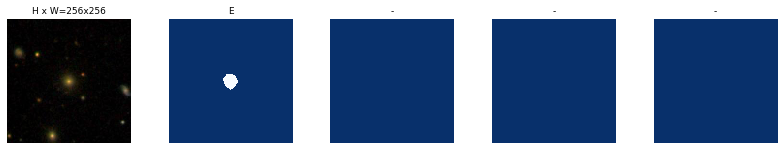

2400


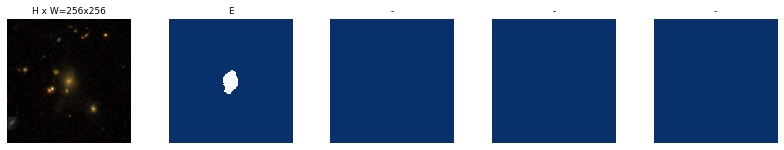

6720


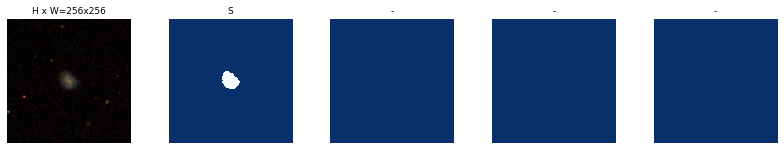

847


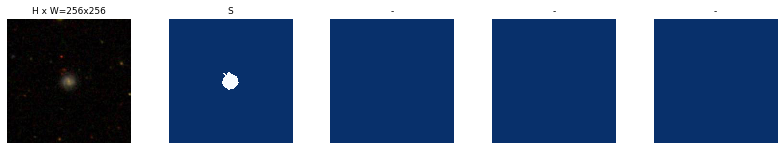

In [17]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    print(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [18]:
dataset_train.class_names

['BG', 'S', 'E']

## Create Model

In [19]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,model_dir=MODEL_DIR)

W1129 16:30:35.848628 140600153843456 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/maskrcnn_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:504: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1129 16:30:35.875692 140600153843456 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/maskrcnn_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1129 16:30:35.903078 140600153843456 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/maskrcnn_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3828: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1129 16:30:35.936343 140600153843456 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/maskrcnn_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3652: The 

In [20]:
pwd

'/home/ubuntu/lab/mask_r_cnn/Mask_RCNN/samples/zoo1'

In [21]:
ROOT_DIR

'/home/ubuntu/lab/mask_r_cnn/Mask_RCNN'

In [22]:
WEIGHTS_PATH = os.path.join(ROOT_DIR,"samples/zoo1/modelos/galaxia_all_1.h5")


WEIGHTS_PATH

'/home/ubuntu/lab/mask_r_cnn/Mask_RCNN/samples/zoo1/modelos/galaxia_all_1.h5'

In [23]:
print("Loading weights ", WEIGHTS_PATH)
model.load_weights(WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

Loading weights  /home/ubuntu/lab/mask_r_cnn/Mask_RCNN/samples/zoo1/modelos/galaxia_all_1.h5


In [24]:
from imgaug import augmenters as iaa

In [25]:
seq_of_aug = iaa.SomeOf((0, 4), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
               iaa.Affine(rotate=180),
               iaa.Affine(rotate=270)]),
    iaa.AddElementwise((-25, 25))
])

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [26]:
def train(model, dataset_train,dataset_val,_layers,_learning_rate, epochs):
    """Train the model."""
    print("Training network ="+_layers)
    history = model.train(dataset_train, dataset_val,
                learning_rate=_learning_rate,
                epochs=epochs,
                layers=_layers,
                augmentation=seq_of_aug
                )
    
    return history

In [27]:
_learning_rate=config.LEARNING_RATE
_learning_rate

0.001

In [ ]:
%%time
history_head = train(model, dataset_train,dataset_val,'heads',_learning_rate, 15)

In [ ]:
model_path = os.path.join(MODEL_DIR, "galaxia_heads.h5")
model.keras_model.save_weights(model_path)

In [ ]:
_learning_rate=config.LEARNING_RATE / 10

In [ ]:
%%time
history_5 = train(model, dataset_train,dataset_val,'5+',_learning_rate, 10)#25

In [ ]:
model_path = os.path.join(MODEL_DIR, "galaxia_plus_5.h5")
model.keras_model.save_weights(model_path)

In [ ]:
_learning_rate=config.LEARNING_RATE / 100
_learning_rate

In [ ]:
%%time
history_3 = train(model, dataset_train,dataset_val,'all',_learning_rate,10 )#35

In [ ]:
model_path = os.path.join(MODEL_DIR, "galaxia_all_1.h5")
model.keras_model.save_weights(model_path)

In [28]:
_learning_rate=config.LEARNING_RATE / 1000
_learning_rate

1e-06

In [ ]:
%%time
history_all = train(model, dataset_train,dataset_val,'all',_learning_rate,25 )#50

Training network =all

Starting at epoch 0. LR=1e-06

Checkpoint Path: /home/ubuntu/lab/mask_r_cnn/Mask_RCNN/samples/zoo1/modelos/galaxia20191129T1631/mask_rcnn_galaxia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a        

W1129 16:31:24.792833 140600153843456 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/maskrcnn_keras/lib/python3.7/site-packages/keras/optimizers.py:744: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [ ]:
model_path = os.path.join(MODEL_DIR, "galaxia_all_final.h5")
model.keras_model.save_weights(model_path)

## Detection

In [33]:
class InferenceConfig(GalaxiaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)



# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

W1128 18:42:48.925191 140713315723008 deprecation_wrapper.py:119] From /home/ubuntu/lab/mask_r_cnn/Mask_RCNN/mrcnn/model.py:720: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.

W1128 18:42:49.028699 140713315723008 deprecation.py:323] From /home/ubuntu/lab/mask_r_cnn/Mask_RCNN/mrcnn/model.py:772: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Loading weights from  /home/ubuntu/lab/mask_r_cnn/Mask_RCNN/samples/zoo1/modelos/galaxia_all_final.h5


original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  613.00000  int64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  126.00000  max:  172.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


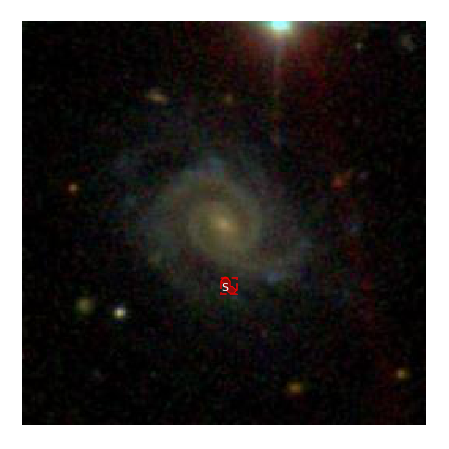

In [34]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -19.04000  max:  239.19000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


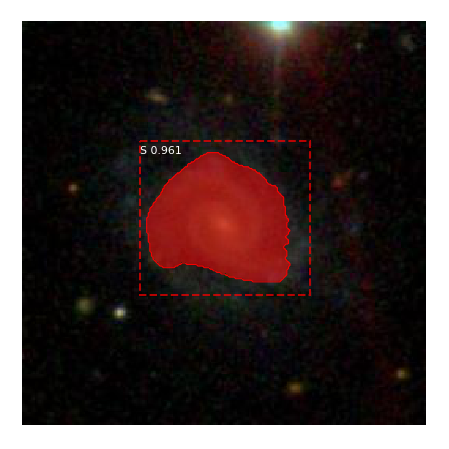

In [35]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [37]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 1990)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.9217755443886098
